In [ ]:
%%capture
!pip install pyod
!pip install scikeras[tensorflow]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, KFold
import keras
import scikeras
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model
from pyod.models.mad import MAD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in and merge datasets

In [ ]:
# Merge datasets from team together
data1 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/final_dataset_1.csv")
print(data1.shape)
print(data1.columns)
data2 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/final_dataset_2.csv")
data2.drop(['Unnamed: 0.1'], axis=1, inplace=True)
print(data2.shape)
print(data2.columns)
data3 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/final_dataset_3.csv")
data3.drop(['Unnamed: 0.1'], axis=1, inplace=True)
print(data3.shape)
print(data3.columns)
data4 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/compiled_dataset.csv")
print(data4.shape)
print(data4.columns)
data = pd.concat([data1, data2, data3, data4], ignore_index=True)
print(data.shape)
print(data.columns)
data.drop(['Unnamed: 0'],  axis=1, inplace=True)
print(data.shape)
print(data.columns)

(50000, 20)
Index(['Unnamed: 0', 'start_date', 'FIRE_SIZE_CLASS', 'category', 'cause',
       'size', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10',
       'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='object')
(50000, 20)
Index(['Unnamed: 0', 'start_date', 'FIRE_SIZE_CLASS', 'category', 'cause',
       'size', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10',
       'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='object')
(50000, 20)
Index(['Unnamed: 0', 'start_date', 'FIRE_SIZE_CLASS', 'category', 'cause',
       'size', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10',
       'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='object')
(10000, 20)
Index(['Unnamed: 0', 'start_date', 'FIRE_SIZE_CLASS', 'category', 'cause',
       'size', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10',
       'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='objec

# Data clean-up

In [ ]:
# Remove any duplicate rows
data.drop_duplicates(inplace=True)

# Remove any rows that have empty values
data.dropna(inplace=True)

# drop non-feature columns
data.drop(['FIRE_SIZE_CLASS', 'start_date'],  axis=1, inplace=True)

num_empty_vals = data[data.isna().any(axis=1)]
print("Num Empty Values: {}".format(num_empty_vals.shape[0]))
print("Shape of Clean Data: {}".format(data.shape))
#data_filtered.to_csv('final_data.csv', index = False) # visually make sure things look good
print("Feature Data Types:")
print((data.dtypes))

Num Empty Values: 0
Shape of Clean Data: (98510, 17)
Feature Data Types:
category     object
cause        object
size        float64
lat         float64
lon         float64
buinfdr     float64
ercnfdr     float64
icnfdr      float64
scnfdr      float64
u10         float64
v10         float64
t2m         float64
blh         float64
cape        float64
lai_hv      float64
lai_lv      float64
slt         float64
dtype: object


## Define features and labels

In [ ]:
# Define input features and labels
target_name = "size"
y = data[target_name] # vector of labels [size of the fire in acres]
X = data.drop(columns=[target_name]) # input features
print(X.columns)

Index(['category', 'cause', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr',
       'scnfdr', 'u10', 'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv',
       'slt'],
      dtype='object')


## Keep n most important features

In [ ]:
# do one-hot encoding for category and cause because they aren't ordinal
X_nn = pd.get_dummies(X, columns = ['category', 'cause'])

# normalize dataset
y_nn = y
columns_to_normalize = ['lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr',
       'scnfdr', 'u10', 'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv',
       'slt']
X_nn[columns_to_normalize] = (X_nn[columns_to_normalize]-X_nn[columns_to_normalize].mean())/X_nn[columns_to_normalize].std()
print(X_nn.head())
# y_nn = (y_nn-y_nn.mean())/y_nn.std()
# print(y_nn.head())

        lat       lon   buinfdr   ercnfdr    icnfdr    scnfdr       u10  \
0 -0.770026 -0.884635  0.327153  0.074889  0.485167  0.268938 -0.093703   
1 -0.273272  1.021270  0.756392  0.879904 -0.319918  0.268938  0.180052   
2  0.823162  1.377326 -0.960566 -0.902630 -0.963986 -0.847030 -1.683584   
3  0.000963  0.245531 -0.960566 -0.442621 -0.963986 -0.847030  0.886563   
4  0.104319  0.057408 -0.459786 -0.557623 -0.400426 -0.475040 -0.294490   

        v10       t2m       blh  ...  cause_Firearms and explosives use  \
0 -0.498447  0.062045 -0.400245  ...                                  0   
1  1.251420  0.156188  0.387475  ...                                  0   
2  0.490325 -2.175046 -0.297219  ...                                  0   
3  2.265784  0.529721  0.353316  ...                                  0   
4 -0.791365  1.032820 -0.674614  ...                                  0   

   cause_Fireworks  cause_Missing data/not specified/undetermined  \
0                0           

# Neural Network Creation

In [ ]:
# create model function
def create_model(init_mode='uniform'):
  model = Sequential()
  model.add(Dense(32, input_dim=n_features, kernel_initializer=init_mode, activation='relu'))
  model.add(Dense(64, input_dim=n_features, kernel_initializer=init_mode, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, kernel_initializer=init_mode, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, kernel_initializer=init_mode, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16, kernel_initializer=init_mode, activation='relu'))
  model.add(Dense(1, kernel_initializer=init_mode, activation='linear'))

  # compile model
  model.compile(loss='mape', optimizer='adam', metrics=['mse','mae','mape'])

  return model

## K-folds

In [ ]:
# Neural network
kfold = KFold(n_splits=5, shuffle=True)
n_features = X_nn.shape[1]

for train, test in kfold.split(X_nn,y_nn):
  model = create_model()

  # train model
  batch_size = int(len(train)/10)
  history = model.fit(X_nn.iloc[train,:], y_nn.iloc[train], epochs=50, batch_size=batch_size, verbose = 0, validation_split = 0.1, shuffle=True)

  # predict on test data
  preds = model.predict(X_nn.iloc[test,:], verbose=0)
  _, mse, mae, mape = model.evaluate(X_nn.iloc[test,:], y_nn.iloc[test])
  print('MSE: %.2f, MAE: %.2f, MAPE: %.2f' % (mse,mae,mape))

616/616 [==============================] - 2s 3ms/step - loss: 82.5508 - mse: 2981534.2500 - mae: 57.1051 - mape: 82.5508
MSE: 2981534.25, MAE: 57.11, MAPE: 82.55
616/616 [==============================] - 1s 2ms/step - loss: 88.5380 - mse: 1191937.5000 - mae: 45.5613 - mape: 88.5380
MSE: 1191937.50, MAE: 45.56, MAPE: 88.54
616/616 [==============================] - 1s 2ms/step - loss: 93.6676 - mse: 16358455.0000 - mae: 84.4894 - mape: 93.6676
MSE: 16358455.00, MAE: 84.49, MAPE: 93.67
616/616 [==============================] - 2s 2ms/step - loss: 83.0713 - mse: 2792800.5000 - mae: 69.6107 - mape: 83.0713
MSE: 2792800.50, MAE: 69.61, MAPE: 83.07
616/616 [==============================] - 1s 2ms/step - loss: 87.1730 - mse: 29557214.0000 - mae: 131.7308 - mape: 87.1730
MSE: 29557214.00, MAE: 131.73, MAPE: 87.17


## Single model trained on train data

Text(0, 0.5, 'Val MAE')

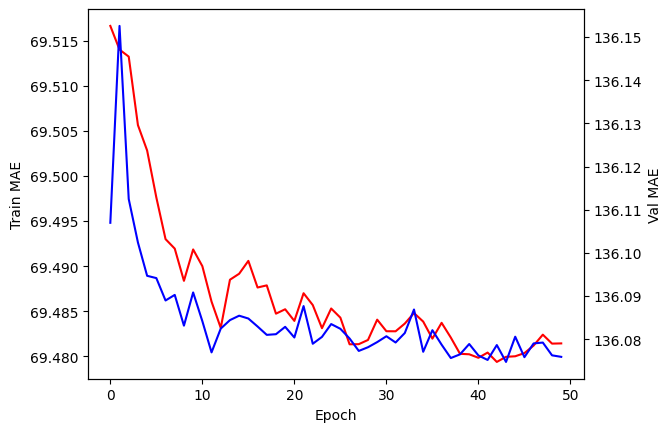

In [ ]:
model = create_model()

# test train split
X_train,X_test,y_train,y_test = train_test_split(X_nn,y_nn,test_size=0.3)

# train model
history = model.fit(X_train, y_train, epochs=50, batch_size=100, verbose = 0, validation_split = 0.1, shuffle=True)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('Train MAE')
ax1.set_xlabel('Epoch')
train = ax1.plot(history.history['mae'], color='red',label='Train')
#ax1.legend(['Train'],loc='upper right')

ax2 = ax1.twinx()
color = 'tab:blue'
val = ax2.plot(history.history['val_mae'], color='blue',label='Val')
ax2.set_ylabel('Val MAE')
#ax2.legend(['Val'],loc='upper center')

ax1.legend( handles=train+val )

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('Train MAE')
ax1.set_xlabel('Epoch')
train = ax1.plot(history.history['mae'], color='red',label='Train')
#ax1.legend(['Train'],loc='upper right')

ax2 = ax1.twinx()
color = 'tab:blue'
val = ax2.plot(history.history['val_mae'], color='blue',label='Test')
ax2.set_ylabel('Test MAE')
#ax2.legend(['Val'],loc='upper center')

ax1.legend( handles=train+val )

NameError: ignored

In [ ]:
# predict on test data
preds = model.predict(X_test, verbose=0)
_, mse, mae, mape = model.evaluate(X_test, y_test)
print('MSE: %.2f, MAE: %.2f, MAPE: %.2f' % (mse,mae,mape))

924/924 [==============================] - 4s 4ms/step - loss: 81.6469 - mse: 3633465.2500 - mae: 70.5367 - mape: 81.6469
MSE: 3633465.25, MAE: 70.54, MAPE: 81.65


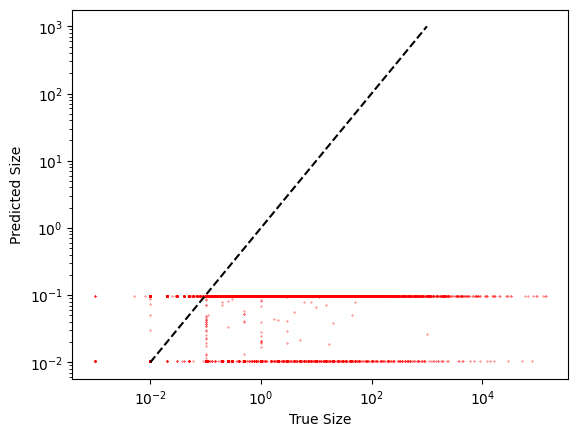

In [ ]:
# visualize predictions
plt.scatter(y_test, preds, s=0.3, marker='.', c='r')
plt.xlabel('True Size')
plt.ylabel('Predicted Size')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.plot([.01,20,1000],[.01,20,1000],c='k',linestyle='--')

# Random Forest Creation

## Cross-validation

fit_time: 140.40237560272217
score_time: 0.4270296573638916
test_neg_mean_absolute_error: 140.80130153146624
train_neg_mean_absolute_error: 132.8084808351226
test_neg_mean_absolute_percentage_error: 483.60254139713606
train_neg_mean_absolute_percentage_error: 450.7046877596364


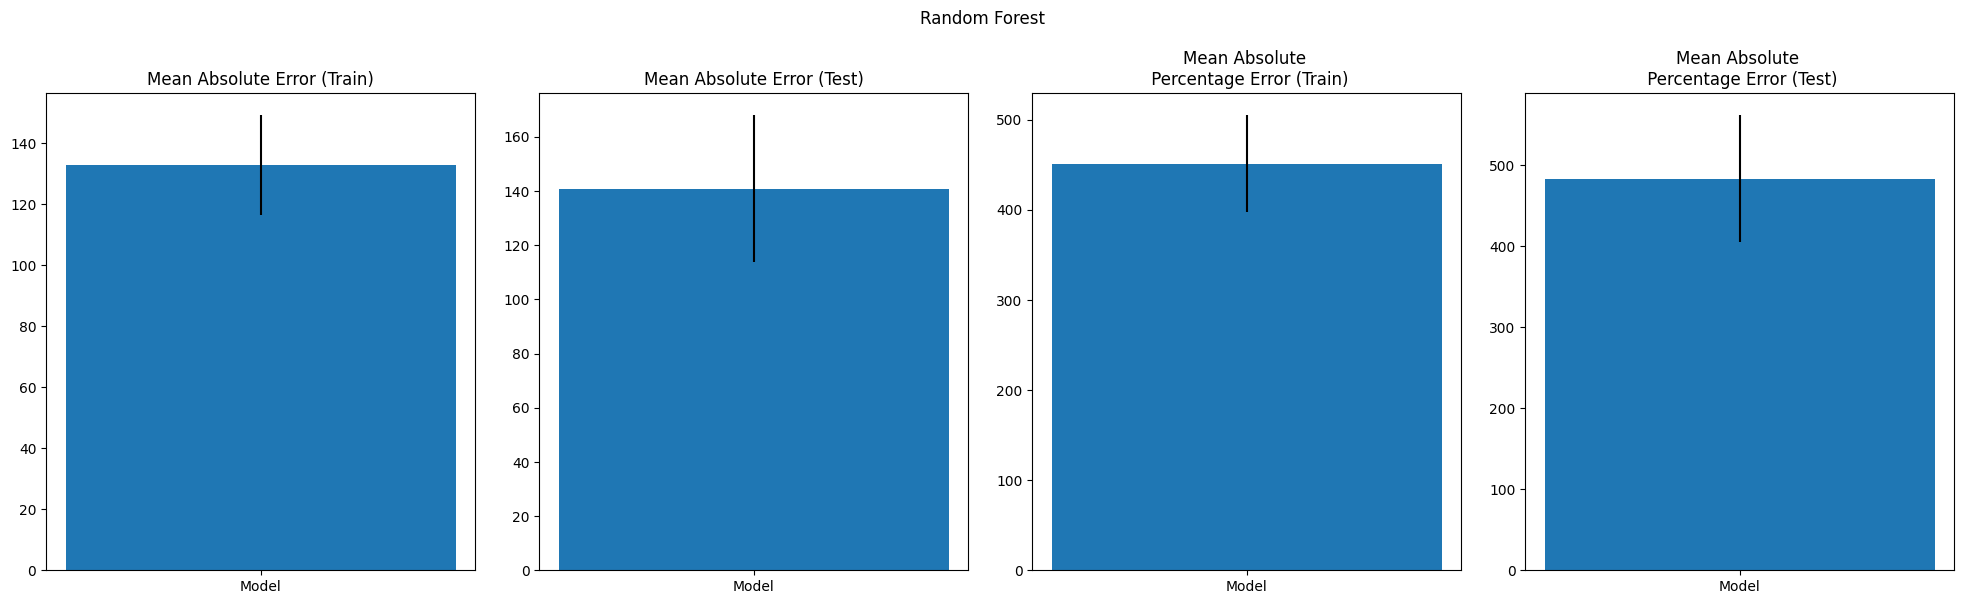

In [ ]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(),
        make_column_selector(dtype_include="object"),
    ),
    remainder="passthrough",
)

random_forest_regressor = make_pipeline(
    ordinal_encoder, RandomForestRegressor(random_state=42, min_samples_leaf=20))

# do cross validation
scoring = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error"]
n_cv_folds = 5
model_result = cross_validate(random_forest_regressor, X, y, cv=n_cv_folds, scoring=scoring, return_train_score=True)

def plot_results(figure_title):
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

    plot_info = [
        ("train_neg_mean_absolute_error", "Mean Absolute Error (Train)", axes[0], None),
        ("test_neg_mean_absolute_error", "Mean Absolute Error (Test)", axes[1], None),
        ("train_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Train)", axes[2], None),
        ("test_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Test)", axes[3], None)
    ]

    x, width = np.arange(1), 0.3
    for key, title, ax, y_limit in plot_info:
        item = model_result[key]

        cv_mean = np.mean(np.abs(item))
        cv_std = np.std(item)

        ax.bar(
            x=x,
            height=cv_mean,
            width=width,
            yerr=cv_std,
            color="C0",
        )
        ax.set(
            title=title,
            xticks=x,
            xticklabels=["Model"],
            ylim=y_limit,
        )

    # Adjust layout and spacing
    plt.tight_layout(pad=2.0)
    fig.suptitle(figure_title, y=1.02)  # Adjust the vertical position of the title

plot_results("Random Forest")
#plt.show()

for key in model_result:
  item = model_result[key]

  cv_mean = np.mean(np.abs(item))
  cv_std = np.std(item)
  print(f'{key}: {cv_mean}')

## Cross-validation with hyperparameter tuning

Best hyperparameters for fold #1:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 50, 'randomforestregressor__max_features': 2}
Best hyperparameters for fold #2:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 2}
Best hyperparameters for fold #3:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 50, 'randomforestregressor__max_features': 2}
Best hyperparameters for fold #4:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 50, 'randomforestregressor__max_features': 4}
Best hyperparameters for fold #5:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 50, 'randomforestregressor__max_features': 4}
train_neg_mean_absolute_error: 132.9825103180159
test_neg_mean_absolute_error: 138.18622433466766
train_neg_mean_absolute_percentage_error: 490.25125034787527
test_neg_mean_absolute_percentage_error: 497.9

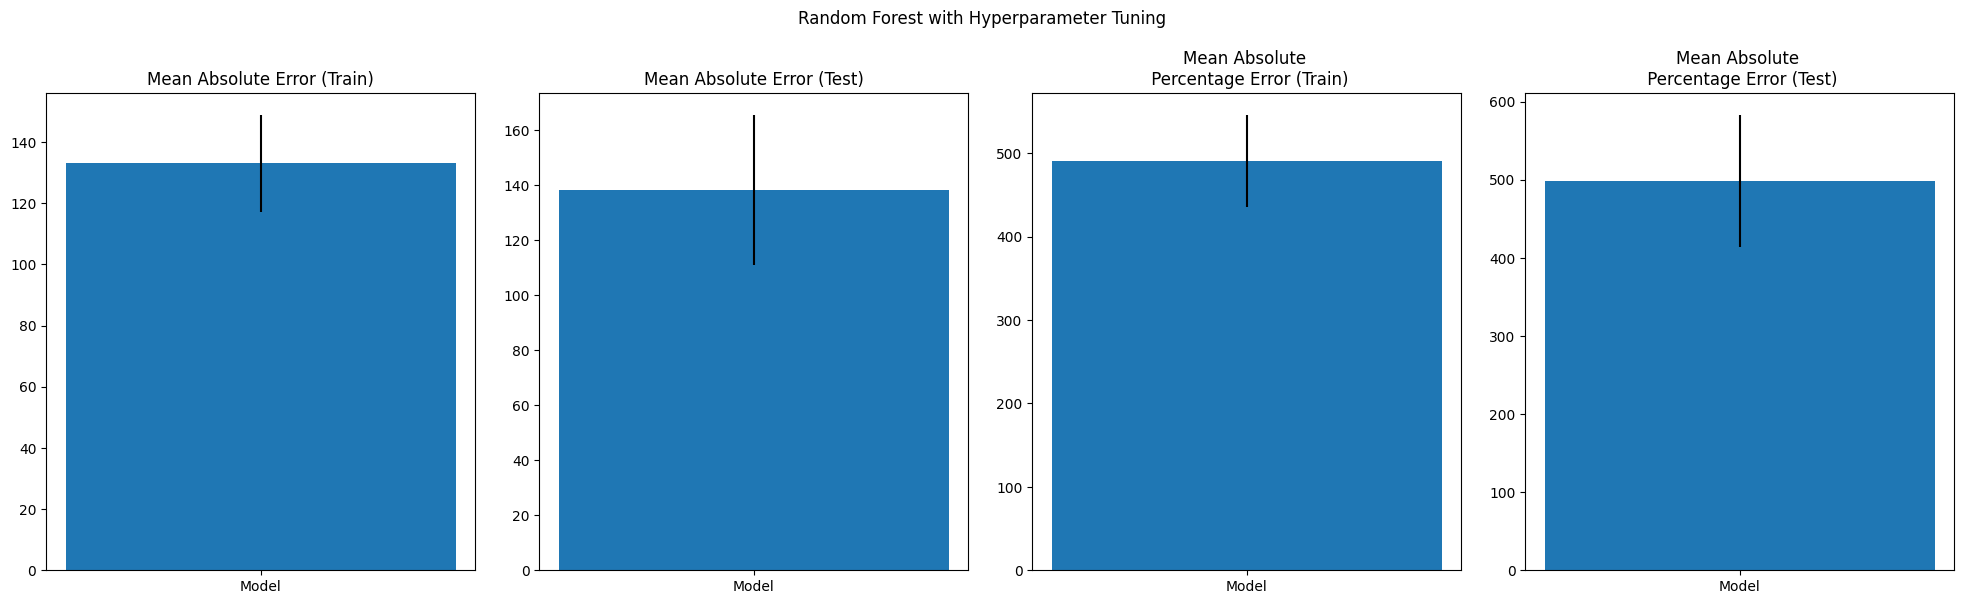

In [ ]:
param_grid = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [10, 50],
    'randomforestregressor__max_features': [2, 4],
    #'min_samples_leaf': [15, 20, 25],
    #'min_samples_leaf': [20],
}

scoring = "neg_mean_absolute_error"
scoring2 = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error"]
model_grid_search = GridSearchCV(random_forest_regressor, param_grid=param_grid, scoring=scoring, n_jobs=2, cv=4)
model_grid_search.fit(X, y)
cv_results = cross_validate(
    model_grid_search, X, y, cv=5, n_jobs=2, return_train_score=True, return_estimator=True, scoring=scoring2
)

def plot_results(figure_title):
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

    plot_info = [
        ("train_neg_mean_absolute_error", "Mean Absolute Error (Train)", axes[0], None),
        ("test_neg_mean_absolute_error", "Mean Absolute Error (Test)", axes[1], None),
        ("train_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Train)", axes[2], None),
        ("test_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Test)", axes[3], None)
    ]

    x, width = np.arange(1), 0.3
    for key, title, ax, y_limit in plot_info:
        item = cv_results[key]

        cv_mean = np.mean(np.abs(item))
        cv_std = np.std(item)

        ax.bar(
            x=x,
            height=cv_mean,
            width=width,
            yerr=cv_std,
            color="C0",
        )
        ax.set(
            title=title,
            xticks=x,
            xticklabels=["Model"],
            ylim=y_limit,
        )

    # Adjust layout and spacing
    plt.tight_layout(pad=2.0)
    fig.suptitle(figure_title, y=1.02)  # Adjust the vertical position of the title

plot_results("Random Forest with Hyperparameter Tuning")

for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )


for key in ["train_neg_mean_absolute_error", "test_neg_mean_absolute_error", "train_neg_mean_absolute_percentage_error", "test_neg_mean_absolute_percentage_error"]:
  item = cv_results[key]

  cv_mean = np.mean(np.abs(item))
  cv_std = np.std(item)
  print(f'{key}: {cv_mean}')

## Test model on test/train split

In [ ]:
# test the output by changing values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
random_forest_regressor.fit(X_train, y_train)
preds = random_forest_regressor.predict(X_test)

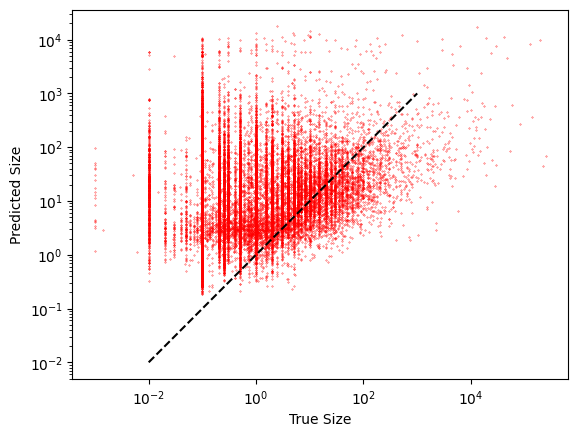

In [ ]:
# visualize predictions
plt.scatter(y_test, preds, s=0.3, marker='.', c='r')
plt.xlabel('True Size')
plt.ylabel('Predicted Size')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.plot([.01,20,1000],[.01,20,1000],c='k',linestyle='--')